In [143]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import sklearn
import time
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline

In [170]:
data = pd.read_csv('test_data.csv')
x = data.loc[:, ('X1', 'X2')].to_numpy()
x = x[0:500, :]
x = x - np.mean(x, 0)
x[:, 0] = x[:, 0]/np.std(x[:, 0])
x[:, 1] = x[:, 1]/np.std(x[:, 1])

index = np.arange(0, len(x))

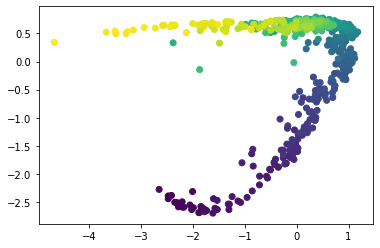

In [171]:
pca = PCA(n_components = 2)
pca.fit(x)
pc1 = pca.components_[:, 0]
plt.scatter(x[:, 0], x[:, 1], c = index)

In [181]:
def abline(a, b):
    plt.plot([a[0], b[0]], [a[1], b[1]], color = 'b', alpha = 0.25)

def proj(a, x):
    # projection of data onto direction a
    return np.kron(np.dot(x, a)/np.dot(a, a), a).reshape(x.shape)

def renorm_parameterisation(p):
    seg_lens = np.linalg.norm(p[1:] - p[0:-1], axis = 1)
    s = np.zeros(p.shape[0])
    s[1:] = np.cumsum(seg_lens)
    s = s/sum(seg_lens)
    return s

def proj_to_segment(x, a, b):
    z = proj(b-a, x-a) 
    z[(z/(b-a))[0] > 1] = b-a
    z[(z/(b-a))[0] < 0] = np.zeros(a.shape)
    return z+a

def dist_to_segment(x, a, b):
    return min([np.linalg.norm(x-a), np.linalg.norm(x-b), np.linalg.norm((x - proj_to_segment(x, a, b)))])

def project(x, p, s):
    s_interp = np.zeros(x.shape[0])
    for i in range(0, x.shape[0]):
        z = x[i, :]
        seg_proj = np.diag(np.einsum('ij,ij->i', z - p[0:-1], p[1:] - p[0:-1])/np.power(np.linalg.norm(p[1:] - p[0:-1], axis = 1), 2))@(p[1:] - p[0:-1])
        proj_dist = (z - p[0:-1]) - seg_proj
        dist_endpts = np.minimum(np.linalg.norm(z - p[0:-1], axis = 1), np.linalg.norm(z - p[1:], axis = 1))
        dist_seg = np.maximum(np.linalg.norm(proj_dist, axis = 1), dist_endpts)
        
        idx_min = np.argmin(dist_seg)
        q = seg_proj[idx_min] 
        s_interp[i] = (np.linalg.norm(q)/np.linalg.norm(p[idx_min + 1, :] - p[idx_min, :]))*(s[idx_min+1]-s[idx_min]) + s[idx_min]
    return s_interp


(-4.974999300530271, 1.4790193143949986, -2.890588536845965, 1.030186601648)

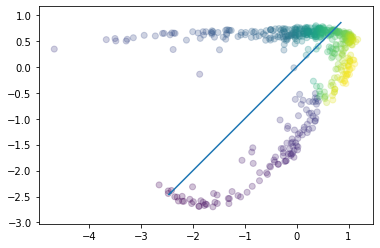

In [182]:
plt.scatter(x[:, 0], x[:, 1], alpha = 0.25, c = index)

p = proj(pc1, x) # starting point for iteration
order = np.argsort([np.linalg.norm(p[0, :] - p[i, :]) for i in range(0, p.shape[0])])
p = p[order]
s = renorm_parameterisation(p)

plt.plot(p[:, 0], p[:, 1])
plt.axis('equal')

i =  0  dt =  0.486583948135376
i =  1  dt =  0.39037299156188965
i =  2  dt =  0.33296895027160645


(-4.9940236369627335,
 1.8785303794767128,
 -2.888325895175665,
 0.982671126571704)

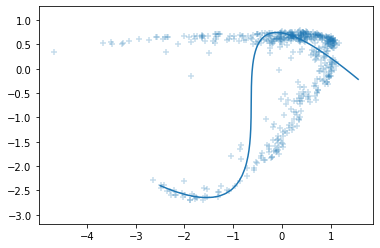

In [183]:
plt.scatter(x[:, 0], x[:, 1], alpha = 0.25, marker = '+')
for i in range(0, 3):
    t0 = time.time()
    s_interp = project(x, p, s)
    print("i = ", i, " dt = ", time.time() - t0)
    order = np.argsort(s_interp)
    s_interp = s_interp[order]
    x = x[order, :]

    spline = [UnivariateSpline(s_interp, x[:, j], k = 3) for j in range(0, x.shape[1])]

    p = np.zeros((len(s_interp), x.shape[1]))
    for j in range(0, x.shape[1]):
        p[:, j] = spline[j](s_interp)

    idx = [i for i in range(0, p.shape[0]-1) if (p[i] != p[i+1]).any()]
    p = p[idx, :]
    s = renorm_parameterisation(p)
plt.plot(p[:, 0], p[:, 1])
plt.axis('equal')